In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [5]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}
train = pd.read_csv('kc_house_data_small_train.csv', dtype=dtype_dict)
test = pd.read_csv('kc_house_data_small_test.csv', dtype=dtype_dict)
validation = pd.read_csv('kc_house_data_validation.csv', dtype=dtype_dict)
#sales = pd.read_csv('kc_house_data_small.csv', dtype=dtype_dict)

In [6]:
def get_numpy_data(data, features, output):
    features = ['constant'] + features # this is how you combine two lists
    # create a new col in dataframe named 'constant'
    data['constant'] = 1 
    
    output_array = data[output].to_numpy()

    feature_matrix = data[features].to_numpy()

    return(feature_matrix, output_array)

def predict_output(feature_matrix, weights):
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix, weights)
    return(predictions)

def normalize_features(features):
    norms = np.linalg.norm(features, axis=0)
    normalize_features = features/norms
    return (normalize_features, norms)

In [7]:
feature_list = ['bedrooms',  
                'bathrooms',  
                'sqft_living',  
                'sqft_lot',  
                'floors',
                'waterfront',  
                'view',  
                'condition',  
                'grade',  
                'sqft_above',  
                'sqft_basement',
                'yr_built',  
                'yr_renovated',  
                'lat',  
                'long',  
                'sqft_living15',  
                'sqft_lot15']
features_train, output_train = get_numpy_data(train, feature_list, 'price')
features_test, output_test = get_numpy_data(test, feature_list, 'price')
features_valid, output_valid = get_numpy_data(validation, feature_list, 'price')

In computing distances, it is crucial to normalize features. Otherwise, for example, the ‘sqft_living’ feature (typically on the order of thousands) would exert a much larger influence on distance than the ‘bedrooms’ feature (typically on the order of ones). We divide each column of the training feature matrix by its 2-norm, so that the transformed column has unit norm.

IMPORTANT: Make sure to store the norms of the features in the training set. The features in the test and validation sets must be divided by these same norms, so that the training, test, and validation sets are normalized consistently.

In [8]:
features_train, norms = normalize_features(features_train) # normalize training set features (columns)
features_test = features_test / norms # normalize test set by training set norms
features_valid = features_valid / norms # normalize validation set by training set norms

To start, let's just explore computing the “distance” between two given houses. We will take our query house to be the first house of the test set and look at the distance between this house and the 10th house of the training set.

To see the features associated with the query house, print the first row (index 0) of the test feature matrix. You should get an 18-dimensional vector whose components are between 0 and 1. Similarly, print the 10th row (index 9) of the training feature matrix.

In [11]:
print(features_test[0])
print(len(features_test[0]))
print(features_train[9])
print(len(features_train[9]))

[ 0.01345102  0.01551285  0.01807473  0.01759212  0.00160518  0.017059
  0.          0.05102365  0.0116321   0.01564352  0.01362084  0.02481682
  0.01350306  0.          0.01345387 -0.01346922  0.01375926  0.0016225 ]
18
[ 0.01345102  0.01163464  0.00602491  0.0083488   0.00050756  0.01279425
  0.          0.          0.01938684  0.01390535  0.0096309   0.
  0.01302544  0.          0.01346821 -0.01346251  0.01195898  0.00156612]
18


 **Quiz Question: What is the Euclidean distance between the query house and the 10th house of the training set? **

In [12]:
euclidean_distance = np.sqrt(np.sum((features_train[9] - features_test[0])**2))
print(euclidean_distance)

0.05972359371398078


Of course, to do nearest neighbor regression, we need to compute the distance between our query house and all houses in the training set. 

To visualize this nearest-neighbor search, let's first compute the distance from our query house (features_test[0]) to the first 10 houses of the training set (features_train[0:10]) and then search for the nearest neighbor within this small set of houses. Through restricting ourselves to a small set of houses to begin with, we can visually scan the list of 10 distances to verify that our code for finding the nearest neighbor is working.

Write a loop to compute the Euclidean distance from the query house to each of the first 10 houses in the training set.

In [13]:
dist_dict = {}
for i in range(0,10):
    dist_dict[i] = np.sqrt(np.sum((features_train[i] - features_test[0])**2))
    print(i, np.sqrt(np.sum((features_train[i] - features_test[0])**2)))

0 0.06027470916295592
1 0.08546881147643746
2 0.06149946435279315
3 0.05340273979294363
4 0.05844484060170442
5 0.059879215098128345
6 0.05463140496775461
7 0.055431083236146074
8 0.052383627840220305
9 0.05972359371398078


**Quiz Question: Among the first 10 training houses, which house is the closest to the query house?**

In [20]:
print(min(dist_dict.items(), key=lambda x: x[1]) )

(8, 0.052383627840220305)


It is computationally inefficient to loop over computing distances to all houses in our training dataset. Fortunately, many of the numpy functions can be vectorized, applying the same operation over multiple values or vectors. We now walk through this process. 

In [22]:
# verify that vectorization works -- why use loops when we can vectorize in numpy
results = features_train[0:3] - features_test[0]
print(results[0] - (features_train[0]-features_test[0]))
# should print all 0's if results[0] == (features_train[0]-features_test[0])
print(results[1] - (features_train[1]-features_test[0]))
# should print all 0's if results[1] == (features_train[1]-features_test[0])
print(results[2] - (features_train[2]-features_test[0]))
# should print all 0's if results[2] == (features_train[2]-features_test[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Perform 1-nearest neighbor regression

Now that we have the element-wise differences, it is not too hard to compute the Euclidean distances between our query house and all of the training houses. First, write a single-line expression to define a variable diff such that diff[i] gives the element-wise difference between the features of the query house and the i-th training house.

In [23]:
diff = features_train - features_test[0]
print(diff[-1].sum()) # sum of the feature differences between the query and last training house
# should print -0.0934339605842

-0.09343399874654643


In [24]:
diff.shape

(5527, 18)

The next step in computing the Euclidean distances is to take these feature-by-feature differences in diff, square each, and take the sum over feature indices. That is, compute the sum of square feature differences for each training house (row in diff).

By default, np.sum sums up everything in the matrix and returns a single number. To instead sum only over a row or column, we need to specifiy the axis parameter described in the np.sum documentation. In particular, axis=1 computes the sum across each row.

Below, we compute this sum of square feature differences for all training houses and verify that the output for the 16th house in the training set is equivalent to having examined only the 16th row of diff and computing the sum of squares on that row alone.


In [27]:
print(np.sum(diff**2, axis=1)[15]) # take sum of squares across each row, and print the 16th sum
print(np.sum(diff[15]**2)) # print the sum of squares for the 16th row -- should be same as above

0.0033070590284564457
0.0033070590284564453


With this result in mind, write a single-line expression to compute the Euclidean distances between the query house and all houses in the training set. Assign the result to a variable distances.

Hint: Do not forget to take the square root of the sum of squares.


In [28]:
np.sum(diff**2, axis=1)

array([0.00363304, 0.00730492, 0.00378218, ..., 0.0032681 , 0.00325555,
       0.00341846])

In [29]:
distances = np.sqrt(np.sum(diff**2, axis=1))
print(distances)

[0.06027471 0.08546881 0.06149946 ... 0.05716729 0.05705739 0.05846758]


In [31]:
print(distances[100]) # Euclidean distance between the query house and the 101th training house
# should print 0.0237082324496

0.023708232416678195


Now you are ready to write a function that computes the distances from a query house to all training houses. The function should take two parameters: (i) the matrix of training features and (ii) the single feature vector associated with the query.

In [32]:
def compute_distances(train_matrix, query_vector):
    diff = train_matrix - query_vector
    distances = np.sqrt(np.sum(diff**2, axis=1))
    return distances

**Quiz Question: Take the query house to be third house of the test set (features_test[2]). What is the index of the house in the training set that is closest to this query house?**

**Quiz Question: What is the predicted value of the query house based on 1-nearest neighbor regression?**

In [39]:
third_house_distance = compute_distances(features_train, features_test[2])
third_house_distance.argsort()[0]

382

In [40]:
output_train[382]

249000.0

## Perform k-nearest neighbor regression

For k-nearest neighbors, we need to find a set of k houses in the training set closest to a given query house. We then make predictions based on these k nearest neighbors. <br>

Using the functions above, implement a function that takes in

- the value of k;
- the feature matrix for the training houses; and
- the feature vector of the query house

and returns the indices of the k closest training houses. For instance, with 2-nearest neighbor, a return value of [5, 10] would indicate that the 6th and 11th training houses are closest to the query house.

In [41]:
def compute_k_nearest_neighbors(k, features_matrix, feature_vector):
    distances = compute_distances(features_matrix, feature_vector)
    return np.argsort(distances, axis = 0)[:k]

**Quiz Question: Take the query house to be third house of the test set (features_test[2]). What are the indices of the 4 training houses closest to the query house?**

In [42]:
compute_k_nearest_neighbors(4, features_train, features_test[2])

array([ 382, 1149, 4087, 3142], dtype=int64)

### Make a single prediction by averaging k nearest neighbor outputs

In [43]:
def compute_distances_k_avg(k, features_matrix, output_values, feature_vector):
    k_neigbors = compute_k_nearest_neighbors(k, features_matrix, feature_vector)
    avg_value = np.mean(output_values[k_neigbors])
    return avg_value   

In [44]:
compute_distances_k_avg(4, features_train, output_train, features_test[2])

413987.5

Compare this predicted value using 4-nearest neighbors to the predicted value using 1-nearest neighbor computed earlier.

### Make multiple predictions

Write a function to predict the value of each and every house in a query set. (The query set can be any subset of the dataset, be it the test set or validation set.) The idea is to have a loop where we take each house in the query set as the query house and make a prediction for that specific house. The new function should take the following parameters:

- the value of k;
- the feature matrix for the training houses;
- the output values (prices) of the training houses; and
- the feature matrix for the query set.

The function should return a set of predicted values, one for each house in the query set.

Hint: To get the number of houses in the query set, use the .shape field of the query features matrix. See the documentation.

In [47]:
def compute_distances_k_all(k, features_matrix, output_values, feature_vector):
    num_of_rows = feature_vector.shape[0]
    predicted_values = []
    for i in range(num_of_rows):
        avg_value = compute_distances_k_avg(k, features_train, output_train, features_test[i])
        predicted_values.append(avg_value)
    return predicted_values

** Quiz Question: Make predictions for the first 10 houses in the test set, using k=10. What is the index of the house in this query set that has the lowest predicted value? What is the predicted value of this house? **

In [48]:
predicted_values = compute_distances_k_all(10, features_train, output_train, features_test[0:10])
print(predicted_values)
print(predicted_values.index(min(predicted_values)))

[881300.0, 431860.0, 460595.0, 430200.0, 766750.0, 667420.0, 350032.0, 512800.7, 484000.0, 457235.0]
6


### Choosing the best value of k using a validation set

There remains a question of choosing the value of k to use in making predictions. Here, we use a validation set to choose this value. Write a loop that does the following:

For k in [1, 2, ..., 15]:
- Makes predictions for each house in the VALIDATION set using the k-nearest neighbors from the TRAINING set.
- Computes the RSS for these predictions on the VALIDATION set
- Stores the RSS computed above in rss_all

<br> Report which k produced the lowest RSS on VALIDATION set.



In [49]:
rss_all = []
for k in range(1,16):    
    predict_value = compute_distances_k_all(k, features_train, output_train, features_valid)
    rss = sum((output_valid - predict_value)**2)
    rss_all.append(rss)
print(rss_all)

[355632427476622.0, 317939124951086.5, 313153111376088.5, 301621468995236.0, 294266734341982.4, 287781925015337.9, 287842561046849.3, 286179146468967.94, 281718696883431.6, 280358603702662.75, 278687700531166.9, 278744728841428.25, 275043861135800.9, 273895810640073.47, 272162684453609.75]


In [51]:
print(rss_all.index(min(rss_all)))

14


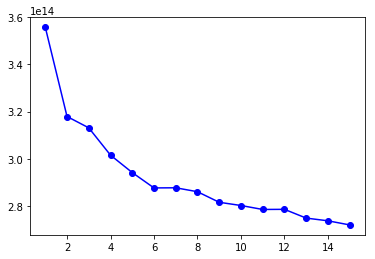

In [52]:
kvals = range(1, 16)
plt.plot(kvals, rss_all,'bo-')

** Quiz Question: What is the RSS on the TEST data using the value of k found above? To be clear, sum over all houses in the TEST set.**

In [53]:
predict_value = compute_distances_k_all(14, features_train, output_train, features_test)
residual = (output_test - predict_value)
rss = sum(residual**2)
print(rss)

133006256365677.28
